In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import json
import time
import os

from src.neuron_heads import head_attribution_over_all_data
from src.datahandlers import ActivatingDataset
from src.utils import tuple_str_to_tuple
from src.neuron_explain import generate_classify_prompt_dict

/Users/clementneo/projects/Neuron_groups/neuron_groups/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [161]:
# filename, prompts_filename = "2023-10-14_18-26-03_gpt2-small_test_20", "2023-10-14_16-16-07_gpt2-small_prompts"
# filename, prompts_filename = "2023-10-14_18-25-30_gpt2-medium_test_20", "2023-10-14_16-15-00_gpt2-medium_prompts"
# filename, prompts_filename = "2023-10-14_18-23-28_gpt2-large_test_20", "2023-10-14_16-13-57_gpt2-large_prompts"
# filename, prompts_filename = "2023-10-15_02-54-36_gpt2-large_mid_test_20", "2023-10-15_00-05-35_gpt2-large_prompts_mid"
# filename, prompts_filename = "2024-02-15_15-54-27_pythia-1.4b_test_20", "2024-02-15_15-04-06_pythia-1.4b_train"

# filename, prompts_filename = "2024-02-16_04-28-46_gpt2-large_test_10p", "2024-02-16_02-52-45_gpt2-large_exp_prompts_10"
# filename, prompts_filename = "2024-02-16_04-28-46_gpt2-large_test_10p", "2024-02-16_02-52-45_gpt2-large_exp_prompts_10"
# filename, prompts_filename = "2024-02-16_07-44-22_gpt2-large_test_20p", "2024-02-16_02-53-52_gpt2-large_exp_prompts_20" ### GPT-2 Large
# filename, prompts_filename = "2024-02-16_10-48-45_gpt2-large_test_30p", "2024-02-16_02-55-00_gpt2-large_exp_prompts_30"

# first one is 
filename, prompts_filename = "2024-02-16_14-11-10_gpt2-large_test_random", "2024-02-16_13-51-07_gpt2-large_random"

# filename, prompts_filename = "2024-02-16_14-51-46_pythia-1.4b_test_acl", "2024-02-15_15-04-06_pythia-1.4b_train" ### Pythia 1.4b
# filename, prompts_filename = "2024-02-16_15-44-26_pythia-160m_test_acl", "2024-02-16_15-38-55_pythia-160m_acl" ### Pythia 160b
    
# filename, prompts_filename = "2024-02-16_16-48-48_gpt2-small_test_aclcn", "2024-02-16_16-22-40_gpt2-small_aclacl"
# filename, prompts_filename = "2024-02-16_16-47-54_gpt2-medium_test_aclcn", "2024-02-16_16-23-04_gpt2-medium_aclacl"
    
# filename, prompts_filename = "2024-02-16_17-43-14_gpt2-large_test_mid_aclcn", "2024-02-16_17-11-42_gpt2-large_mid_aclacl"

# Load all the files
with open(f'../experiment_data/6_explanation_eval/{filename}.json') as f:
    prompt_classifications = json.load(f)

# with open(f'../experiment_data/6_explanation_eval/{filename_plus}.json') as f:
#     prompt_classifications_plus = json.load(f)


head_attributions_filename = prompt_classifications['prior_filename']
with open(f'../experiment_data/4_head_attributions/{head_attributions_filename}.json') as f:
    head_attributions = json.load(f)

with open(f'../experiment_data/4_head_attributions/{prompts_filename}.json') as f:
    nh_to_pos_neg_prompts = json.load(f)['nh_to_pos_neg_prompts']

# with open(f'../experiment_data/4_head_attributions/{prompts_filename_plus}.json') as f:
    # nh_to_pos_neg_prompts_plus = json.load(f)['nh_to_pos_neg_prompts']

trimmed_texts_filename = head_attributions['prior_filename']
with open(f'../experiment_data/3_trimmed_texts/{trimmed_texts_filename}.json') as f:
    trimmed_texts = json.load(f)

max_activating_filename = trimmed_texts['prior_filename']
with open(f'../experiment_data/2_max_activating_texts/{max_activating_filename}.json') as f:
    max_activating = json.load(f)

neuron_filename = max_activating['prior_filename']
with open(f'../experiment_data/1_next_token_neurons/{neuron_filename}.json') as f:
    neurons_data = json.load(f)

neurons = [tuple_str_to_tuple(neuron_str) for neuron_str in head_attributions['head_attributions'].keys()]
neuron_to_token = {tuple_str_to_tuple(neuron_str): token_data['token'] for neuron_str, token_data in neurons_data['neurons'].items()}

# Load the classifications
classify_filepath = prompt_classifications['classify_filepath'][:-6] + '_results.jsonl'
with open(classify_filepath, 'r') as f:
    lines = f.readlines()
    lines = [json.loads(line) for line in lines]

class_prompt_to_class = {x[0]['messages'][0]['content']: x[1]['choices'][0]['message']['content'] for x in lines}

# classify_filepath_plus = classify_filepath[:-len("_results.jsonl")] + "_10_results.jsonl"
# with open(classify_filepath_plus, 'r') as f:
#     lines = f.readlines()
#     lines = [json.loads(line) for line in lines]

# class_prompt_to_class_plus = {x[0]['messages'][0]['content']: x[1]['choices'][0]['message']['content'] for x in lines}



# # Combine the dictionaries
# print(len(class_prompt_to_class))
# print(len(class_prompt_to_class_plus))
# class_prompt_to_class.update(class_prompt_to_class_plus)
# print(len(class_prompt_to_class))

# FOR THE MID TEST
# Load the classifications
# classify_filepath = prompt_classifications['classify_filepath'][:-9] + '_20_results.jsonl'
# with open(classify_filepath, 'r') as f:
#     lines = f.readlines()
#     lines = [json.loads(line) for line in lines]

# class_prompt_to_class = {x[0]['messages'][0]['content']: x[1]['choices'][0]['message']['content'] for x in lines}

# classify_filepath_plus = classify_filepath[:-len("_results.jsonl")] + "_10_results.jsonl"
# with open(classify_filepath_plus, 'r') as f:
#     lines = f.readlines()
#     lines = [json.loads(line) for line in lines]

# class_prompt_to_class_plus = {x[0]['messages'][0]['content']: x[1]['choices'][0]['message']['content'] for x in lines}



# Combine the dictionaries
print(len(class_prompt_to_class))
# print(len(class_prompt_to_class_plus))
# class_prompt_to_class.update(class_prompt_to_class_plus)
print(len(class_prompt_to_class))

15640
15640


In [162]:
nh_to_pos_count = {}
for nh, (pos, neg) in nh_to_pos_neg_prompts.items():
    nh_to_pos_count[nh] = len(pos)

In [163]:
# We have class_prompt_to_class, and nh to {class_prompt: trunc prompt}
nh_to_data = prompt_classifications['classify_prompts']
# nh_to_data_plus = prompt_classifications_plus['classify_prompts']
# for nh, class_prompt_to_trunc_dict in nh_to_data_plus.items():
#     if nh not in nh_to_data:
#         nh_to_data[nh] = {}
#     nh_to_data[nh].update(class_prompt_to_trunc_dict)

head_attributions_dict = {tuple_str_to_tuple(k): v for k, v in head_attributions['head_attributions'].items()}

nh_to_results = {}
nh_to_egs = {}

total = 0
bad = 0
for nh, class_prompt_to_trunc_dict in nh_to_data.items():
    nh_tuple = tuple_str_to_tuple(nh)
    neuron, head = (nh_tuple[0], nh_tuple[1]), nh_tuple[2]
    tp, fp, tn, fn = 0, 0, 0, 0
    tp_list, fp_list, tn_list, fn_list = [], [], [], []

    for class_prompt, trunc_prompt in class_prompt_to_trunc_dict.items():
        total += 1
        try:
            answer = class_prompt_to_class[class_prompt] # "Yes" or "No"
            # answer = class_prompt_stripped_to_class[class_prompt.strip()] # "Yes" or "No"
        except:
        # print(class_prompt)
            bad += 1
            continue
        trunc_prompt_without_token = trunc_prompt[:-len(neuron_to_token[neuron])]
        head_is_active = head in head_attributions_dict[neuron][trunc_prompt_without_token]
        if head_is_active:
            if answer == "Yes":
                tp += 1
                tp_list.append(trunc_prompt)
            elif answer == "No":
                fn += 1
                fn_list.append(trunc_prompt)
        else:
            if answer == "Yes":
                fp += 1
                fp_list.append(trunc_prompt)
            elif answer == "No":
                tn += 1
                tn_list.append(trunc_prompt)

    nh_to_egs[nh] = {'tp': tp_list, 'fp': fp_list, 'tn': tn_list, 'fn': fn_list}
    nh_to_results[nh] = {'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn}


In [164]:
bad/total

0.0

In [165]:
# Calculate average precision, accuracy and recall
precisions = []
recalls = []
accuracies = []
for nh, result in nh_to_results.items():
    tp, fp, tn, fn = result['tp'], result['fp'], result['tn'], result['fn']
    if nh_to_results[nh]["tp"] + nh_to_results[nh]["fn"] == 0 or nh_to_results[nh]["tn"] + nh_to_results[nh]["fp"] == 0:
        continue
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    accuracies.append(accuracy)

mean = sum(accuracies) / len(accuracies)
var = sum((x - mean) ** 2 for x in accuracies) / len(accuracies)
std = var ** 0.5

print(f"Mean: {mean}, Std: {std}")

# Calculate skew of accuracy
# Calculate the skew 
from scipy.stats import skew, skewtest
print(skew(accuracies))

Mean: 0.5887581621277274, Std: 0.2091330760131158
-0.22952532083153745


Text(0, 0.5, 'Number of Heads')

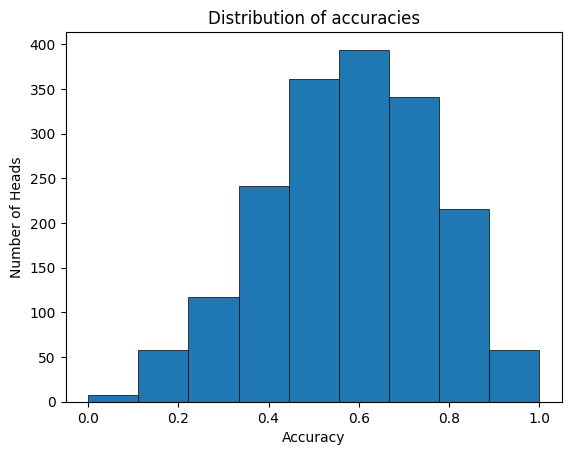

In [166]:
from matplotlib import pyplot as plt
import numpy as np

bins = np.linspace(0, 1.0, 10)
plt.hist(accuracies, bins, label='Overall Accuracy', linewidth=0.5, edgecolor="black")
plt.title("Distribution of accuracies")
plt.xlabel("Accuracy")
plt.ylabel("Number of Heads")

In [167]:
# Sort nh_to_results by by accuracy
nh_to_tpr = {nh: nh_to_results[nh]["tp"] / (nh_to_results[nh]["tp"] + nh_to_results[nh]["fn"])  if nh_to_results[nh]["tp"] + nh_to_results[nh]["fn"] != 0 else None for nh in nh_to_results}
nh_to_tnr = {nh: nh_to_results[nh]["tn"] / (nh_to_results[nh]["tn"] + nh_to_results[nh]["fp"]) if nh_to_results[nh]["tn"] + nh_to_results[nh]["fp"] != 0 else None for nh in nh_to_results}

nh_to_tpr_tnr_avg = {}
for nh in nh_to_results:
    # if all active or inactive examples, skip
    if nh_to_results[nh]["tp"] + nh_to_results[nh]["fn"] == 0 or nh_to_results[nh]["tn"] + nh_to_results[nh]["fp"] == 0:
        continue
    tpr = nh_to_tpr[nh]
    tnr = nh_to_tnr[nh]
    # If one is none, then the average is the other
    if tpr is None:
        nh_to_tpr_tnr_avg[nh] = tnr
    elif tnr is None:
        nh_to_tpr_tnr_avg[nh] = tpr
    else:
        nh_to_tpr_tnr_avg[nh] = (tpr + tnr) / 2

# nh_to_tpr_tnr_avg_no_None = {k: v for k, v in nh_to_tpr_tnr_avg.items() if v is not None}
# nh_to_accuracy = {nh: (nh_to_results[nh]["tp"] + nh_to_results[nh]["tn"]) / (nh_to_results[nh]["tp"] + nh_to_results[nh]["tn"] + nh_to_results[nh]["fp"] + nh_to_results[nh]["fn"]) for nh in nh_list}
# nh_to_accuracy = {k: v for k, v in sorted(nh_to_accuracy.items(), key=lambda item: item[1], reverse=True)}
# nh_list_sorted_by_accuracy = list(nh_to_accuracy.keys())
nh_to_tpr_tnr_avg = {k: v for k, v in sorted(nh_to_tpr_tnr_avg.items(), key=lambda item: item[1], reverse=True)}
nh_list_sorted_by_head_eval_score = list(nh_to_tpr_tnr_avg.keys())

In [168]:
eval_scores = list(nh_to_tpr_tnr_avg.values())
# Calculate the skew 
from scipy.stats import skew, skewtest
print(skew(eval_scores))
print(skewtest(eval_scores, alternative='greater'))

0.23001743370579764
SkewtestResult(statistic=3.943423855127628, pvalue=4.016325179021836e-05)


In [169]:
import numpy as np
print(np.mean(list(nh_to_tpr_tnr_avg.values())))
print(np.std(list(nh_to_tpr_tnr_avg.values())))


# GPT-2 Small: 0.639 mean, 0.178 std
# GPT-2 Medium: 0.616 mean, 0.159 std
# GPT-2 Large: 0.602 mean, 0.171 std
# GPT-2 Large Mid: 0.560 mean, 0.158 std

# 10 prompts: 0.571, 0.227

# GPT2 small: 0.650 mean, 0.194 std, -0.122 skew, p-value 0.789
# GPT2 med: 0.610 mean, 0.201 std, +0.113 skew, p-value 0.097
# GPT2 Large: 0.575 mean, 0.227 std, -0.132 skew, p-value 0.960
# Pythia 1.4b: 0.574 mean, 0.176 std, -0.098 skew, p-value 0.832
# Pythia 160m: 0.621 mean, 0.206 std, -0.038 skew, p-value 0.602
# GPT2 Large Random: 0.558 mean, 0.191 std, +0.230 skew, p-value 4.016325179021836e-05

0.5580559537081276
0.19111006180989148


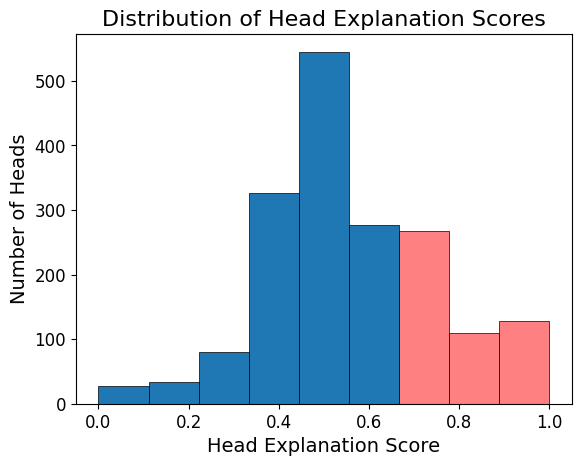

In [170]:
import numpy as np
bins = np.linspace(0, 1, 10)
import matplotlib.pyplot as plt
hist = plt.hist(nh_to_tpr_tnr_avg.values(), bins, label='Overall Accuracy', linewidth=0.5, edgecolor="black")
plt.title("Distribution of Head Explanation Scores")
plt.xlabel("Head Explanation Score")
plt.ylabel("Number of Heads")
# Make the title two times bigger
plt.title("Distribution of Head Explanation Scores", fontsize=16)
# Make the labels two times bigger
plt.xlabel("Head Explanation Score", fontsize=14)
plt.ylabel("Number of Heads", fontsize=14)
# Make the ticks font size smaller
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

bars = hist[2]
# Color the right three bars red
for i in range(-3, 0):
    bars[i].set_fc((1.0, 0.5, 0.5))
# plt.ylim(0,60)

# Save as pdf
plt.savefig(f"../figures_acl/gpt2_large_rand_exp.pdf", bbox_inches='tight')

In [94]:
def get_printout():
    return_str = ""

    for nh in nh_list_sorted_by_head_eval_score:
        nh_tuple = tuple_str_to_tuple(nh)
        token = neuron_to_token[(nh_tuple[0], nh_tuple[1])]
        return_str += f"{nh}, '{token}', {nh_to_tpr_tnr_avg[nh]}\n"

        # Hacky way to get explanation
        explanation = list(nh_to_data[nh].keys())[0].split("\nIs the given example")[0]

        return_str += f"This head is active when {explanation}.\n"
        results = nh_to_egs[nh]
        # tp, tn, fp, fn = results['tp'], results['tn'], results['fp'], results['fn']
        return_str += "Examples where the head is active:\n"
        for eg in results['tp']:
            return_str += f"✅ {eg}\n"
        for eg in results['fn']:
            return_str += f"❌ {eg}\n"

        return_str += "Examples where the head is inactive:\n"
        for eg in results['tn']:
            return_str += f"✅ {eg}\n"
        for eg in results['fp']:
            return_str += f"❌ {eg}\n"
        return_str += "\n"

    return return_str

with open("eval_results_full_gpt2-large_mid.txt", "w") as f:
    f.write(get_printout())
